Alex Jones (alexander.g.jones.23@dartmouth.edu) <br>
March 15, 2022 <br>
LING 28 (Rolando Coto-Solano), Winter 2022 <br>
Final Project


---

This notebook contains code for mining pseudoparallel sentence pairs between Kalaallisut and Danish monolingual data.

In [75]:
!pip install transformers[sentencepiece] faiss-gpu
!pip install -U sentence-transformers
import torch
from torch import nn
from sentence_transformers import SentenceTransformer, util
import numpy as np
import faiss
import youtokentome as yttm
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [26]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    
    if torch.cuda.get_device_name(0) == "Tesla K40m":
        raise GPUError("GPU Error: No compatible GPU found")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Quadro RTX 6000


In [27]:
model_name = 'LaBSE'
sentence_model = SentenceTransformer(model_name)
sentence_model.cuda()

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 768, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
  (3): Normalize()
)

In [28]:
# Setting up the GPU with Faiss
GPU = faiss.StandardGpuResources()

In [67]:
'''

Params
******
src_emb: array of size number_of_source_sentences X embedding_dimension
tgt_emb: array of size number_of_target_sentences X embedding_dimension
k: number of neighbors to return
batch_size: batch size

Returns
*******
cos_sims: cosine similarity scores for each of k nearest neighbors for each source sentence
inds: target indices of k nearest neighbors for each source sentence

Modeled off of LASER source code: https://github.com/facebookresearch/LASER/blob/master/source/mine_bitexts.py

'''

def knnSearch(src_emb, tgt_emb, k=1, batch_size=1):
    emb_dim = src_emb.shape[1] # Embedding dimension
    num_src_sents = src_emb.shape[0]
    num_tgt_sents = tgt_emb.shape[0]
    cos_sims = np.zeros((num_src_sents, k), dtype=np.float32)
    inds = np.zeros((num_src_sents, k), dtype=np.int64)
    for s_min in tqdm(range(0, num_src_sents, batch_size)):
        s_max = min(s_min + batch_size, num_src_sents)
        src_sims = []
        src_inds = []
        for t_min in range(0, num_tgt_sents, batch_size):
            t_max = min(t_min + batch_size, num_tgt_sents)
            idx = faiss.IndexFlatIP(emb_dim)
            idx = faiss.index_cpu_to_gpu(GPU, 0, idx)
            idx.add(tgt_emb[t_min : t_max])
            src_sim, src_ind = idx.search(src_emb[s_min : s_max], min(k, t_max-t_min))
            src_sims.append(src_sim)
            src_inds.append(src_ind + t_min)
            del idx
        src_sims = np.concatenate(src_sims, axis=1)
        src_inds = np.concatenate(src_inds, axis=1)
        sorted_inds = np.argsort(-src_sims, axis=1)
        for i in range(s_min, s_max):
            for j in range(k):
                cos_sims[i, j] = src_sims[i-s_min, sorted_inds[i-s_min, j]]
                inds[i, j] = src_inds[i-s_min, sorted_inds[i-s_min, j]]
    return cos_sims, inds

In [30]:
# Retrieves k-nearest neighbor indices and similarity means for margin scoring
# If forward: finds neearest neighbors and indices for all source sentences
# If backward: finds nearest neighbors and indices for all target sentences
# In the approach implemented in our paper, we perform both forward and backward search

def directedMeansAndInds(src_emb, tgt_emb, forward=False, backward=False, k=1, batch_size=1):
    assert forward != backward, "Please choose either forward or backward"
    if forward:
        cos_sims, inds = knnSearch(src_emb, tgt_emb, min(tgt_emb.shape[0], k), batch_size)
        return cos_sims.mean(axis=1), inds
    elif backward:
        cos_sims, inds = knnSearch(tgt_emb, src_emb, min(src_emb.shape[0], k), batch_size)
        return cos_sims.mean(axis=1), inds

In [145]:
'''

Params
******
src_embs: array of size number_of_source_sentences X embedding_dimension
tgt_embs: array of size number_of_source_sentences X embedding_dimension
batch_size: batch size
num_neighbors: number of neighbors

Returns
*******
concat_pairs: list of mined sentence pairs
margin_scores: list of scores corresponding to mined pairs

'''


def mineSentencePairs(src_embs, tgt_embs, batch_size=100, num_neighbors=4):

    # Retrieve means and indices in the forward direction . . .
    fwd_means, fwd_inds = directedMeansAndInds(src_embs, tgt_embs, forward=True, k=num_neighbors, batch_size=batch_size)
    # . . . and in the backward direction
    bwd_means, bwd_inds = directedMeansAndInds(src_embs, tgt_embs, backward=True, k=num_neighbors, batch_size=batch_size)

    fwd_margin_scores = np.zeros(fwd_inds.shape)
    for i in tqdm(range(fwd_inds.shape[0])):
        for j in range(fwd_inds.shape[1]):
            tgt_ind = fwd_inds[i,j]
            # Compute ratio margin score between each source sentence and each of its k-nearest neighbors
            margin_score = (src_embs[i].dot(tgt_embs[tgt_ind])) / np.average((fwd_means[i], bwd_means[tgt_ind]))
            # Store the result
            fwd_margin_scores[i,j] = margin_score
    
    # We will store the source index, target index, and margin score for the best
    # pairs found using forward search
    best = np.zeros((fwd_inds.shape[0], 3))
    # Take pair that maximizes margin score for each source sentence
    best_inds = fwd_inds[np.arange(src_embs.shape[0]), fwd_margin_scores.argmax(axis=1)]
    for i in range(fwd_inds.shape[0]):
        best_score, ind = (np.max(fwd_margin_scores[i]), np.argmax(fwd_margin_scores[i]))
        best[i] = ((i+1, best_inds[i]+1, best_score)) # Assumption is that GROUND TRUTH VALUES ARE 1-INDEXED!!!

    # Repeat process in backward direction (finding matches in source text for target sentences)
    bwd_margin_scores = np.zeros(bwd_inds.shape)
    for i in tqdm(range(bwd_inds.shape[0])):
        for j in range(bwd_inds.shape[1]):
            tgt_ind = bwd_inds[i,j]
            margin_score = (tgt_embs[i].dot(src_embs[tgt_ind])) / np.average((bwd_means[i], fwd_means[tgt_ind]))
            bwd_margin_scores[i,j] = margin_score
            
    bwd_best = np.zeros((bwd_inds.shape[0], 3))
    best_inds = bwd_inds[np.arange(tgt_embs.shape[0]), bwd_margin_scores.argmax(axis=1)]
    for i in range(bwd_inds.shape[0]):
        best_score, ind = (np.max(bwd_margin_scores[i]), np.argmax(bwd_margin_scores[i]))
        bwd_best[i] = ((best_inds[i]+1, i+1, best_score))
    
    # Best triples (src_idx, tgt_idx, margin_score) from forward/backward searches
    fwd_best = [tuple(best[i]) for i in range(best.shape[0])]
    bwd_best = [tuple(bwd_best[i]) for i in range(bwd_best.shape[0])]

    pairs_and_scores = []
    # Take UNION of forward and backward searches
    pairs_and_scores = list(set(fwd_best) | set(bwd_best))

    pairs_and_scores = list(dict.fromkeys(pairs_and_scores))
    concat_pairs = [(triplet[0], triplet[1]) for triplet in pairs_and_scores] # Store indices only
    concat_pairs_int = []
    for tup in concat_pairs:
        concat_pairs_int.append((int(tup[0]), int(tup[1]))) # Ground-truth indices are ints, so change type
    concat_pairs = concat_pairs_int

    margin_scores = [triplet[2] for triplet in pairs_and_scores] # Store scores only
                                    
    return concat_pairs, margin_scores

In [146]:
# Read in monolingual sentences
kl_sents = open('./data/kl/mono.kl', 'r').readlines()
da_sents = open('./data/da/mono.da', 'r').readlines()

In [271]:
# Train BPE model on Kalaallisut data
yttm.BPE.train(data='./data/kl/mono.kl', 
               vocab_size=10000, 
               model='../kl_bpe.model')

In [272]:
bpe_model = yttm.BPE(model='../kl_bpe.model') # load BPE model

In [273]:
def getBPETokens(sentences, bpe_model):
    '''
    Tokenize sentences using trained BPE model
    '''
    tokenized_sents = []
    for sentence in tqdm(sentences):
        bpe_toks = bpe_model.encode(sentence, output_type=yttm.OutputType.SUBWORD)
        just_toks = ''.join([tok+' ' for tok in bpe_toks]).replace('▁', '')
        tokenized_sents.append(just_toks)
    return tokenized_sents

In [274]:
# Segment Kalaallisut sentences using BPE
kl_sents_seg = getBPETokens(kl_sents, bpe_model)

100%|██████████| 93092/93092 [00:07<00:00, 12633.38it/s]


In [151]:
kl_embs = sentence_model.encode(kl_sents) # Embed sentences using LaBSE (this'll take a minute, be patient)

In [152]:
da_embs = sentence_model.encode(da_sents)

In [153]:
sent_pairs, scores = mineSentencePairs(kl_embs, da_embs) # Mine pseudoparallel sentences and keep margin scores

100%|██████████| 140801/140801 [00:08<00:00, 16323.70it/s]


Text(0.5, 0, 'Margin score')

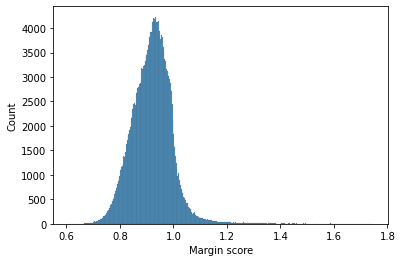

In [154]:
sns.histplot(scores)
plt.xlabel('Margin score')

In [172]:
MARGIN_THRESHOLD = 1.2
kl_sents_mined = [kl_sents[pair[0]-1] for pair in sent_pairs]
da_sents_mined = [da_sents[pair[0]-1] for pair in sent_pairs]

In [173]:
mined_1_20 = [(kl_sents_mined[i], da_sents_mined[i]) for i in range(len(kl_sents_mined)) if scores[i] > MARGIN_THRESHOLD]

In [174]:
mined_1_20 = [pair for pair in mined_1_20 if pair[0]!=pair[1]]

In [175]:
print(f'Mined {len(mined_1_20)} sentence pairs with a margin threshold of {MARGIN_THRESHOLD}')

Mined 1323 sentence pairs with a margin threshold of 1.2


In [176]:
mined_1_20

[('junior wowow juulli juullikkunni allakaatitat assigiinngittut\n',
  'det har man ikk set før på færøern og det gør også det er svært inddæmm smitten siger landslægen\n'),
 ('timersornermi nammineq piumassutsimik ikiuukkusussuseq nukittorsarniarlugu timersoqatigiit kattuffiat atorfinitsitsivoq\n',
  'januar sidst uge skrev knr halvdelen af de containerbolig der er beregnet til de hjemløs står tomm\n'),
 ('8:30, irena arcticalu aamma nuummiit aallassangatinneqarluni sapaatiuppat 3\n',
  'nalakkersuisoq kultur nick nielsen fremhæver støtte til nationalteateret nationalbanken redaktionen tirsdag\n'),
 ('pele broberg aamma peter olsen paragraf naapertorlugu apeqquteqartoqarnerani imminnut assortuuttunik akissuteqartut dori j\n',
  'politi brandstiftels nuuk efterforsk sermitsiaq\n'),
 ('greenland facil servic sermitsiaq\n',
  'det skal bemaerkes, at fcl-containere erstatningsmaessigt betragtes som et kolli, med mindre der er tale om "shippers own" containere, i hvilket tilfaelde denne er

### Trying dictionaries from https://www.mobileread.com/forums/showthread.php?t=20480&page=11
### With both Kl-Da and Kl-En, we're about to translate $\approx 16\%$ of the words in the Kl corpus

In [319]:
kl_da_dict = pd.read_excel('./data/kl-da/kl-da_dict.xls')

In [320]:
kl_da_dict.rename(columns={'Allattaasitaaq - New orthography': 'Kl', 'Qallunaatut - Danish': 'Da'}, inplace=True)

In [321]:
kl_da_dict

,Kl,Da
0,NaN,NaN
1,a´,ih! nå da
2,aa,hør!; hej!
3,aannguaq,du der!
4,aarsuaq-una,dit spektakel!
...,...,...
20159,viinnissat,vindruer
20160,viinnequtip paarmiorfia,NaN
20161,viinniisivik,vinkande
20162,viinnisorpoq,drikker vin


In [322]:
kl_da_dict = {kl:da for kl,da in zip(kl_da_dict['Kl'], kl_da_dict['Da'])}

In [323]:
# Translate Kalaallisut words to Danish
kl_sents_trans_da = []
count = 0
total = 0
for sent in tqdm(kl_sents_seg):
    trans_sent = ''
    for word in sent.split():
        if word in kl_da_dict:
            transl = kl_da_dict[word]
            count += 1
        else:
            transl = word
        total += 1
        trans_sent += word + ' '
    kl_sents_trans_da.append(trans_sent)

100%|██████████| 93092/93092 [00:01<00:00, 63116.69it/s]


In [324]:
print(f'{round((count/total)*100, 2)}% of words were translated to Danish')

7.97% of words were translated to Danish


In [325]:
kl_en_dict = {}
with open('./data/en/kl-en_dict.txt', 'r') as f:
    reader = csv.reader(f, delimiter='\t')
    for line in reader:
        kl_en_dict[line[0]] = line[1]

In [326]:
# Translate other Kalaallisut words to EEnglish
kl_sents_trans_da_en = []
for sent in tqdm(kl_sents_trans):
    trans_sent = ''
    for word in sent.split():
        if word in kl_en_dict:
            transl = kl_en_dict[word]
            count += 1
        else:
            transl = word
        trans_sent += word + ' '
    kl_sents_trans_da_en.append(trans_sent)

100%|██████████| 93092/93092 [00:01<00:00, 71246.60it/s]


In [327]:
print(f'{round((count/total)*100, 2)}% of words were translated to English or Danish')

15.93% of words were translated to English or Danish


In [328]:
kl_embs_trans = sentence_model.encode(kl_sents_trans_da_en) # Embed the "code-switched" Kalaallisut

In [331]:
sent_pairs, scores = mineSentencePairs(kl_embs_trans, da_embs) # Mine pseudoparallel seentences

100%|██████████| 140801/140801 [00:09<00:00, 15292.27it/s]


In [393]:
# Only keep sentence pairs above margin threshold
MARGIN_THRESHOLD = 0
kl_sents_mined = [kl_sents[pair[0]-1] for pair in sent_pairs]
kl_sents_mined_trans = [kl_sents_trans_da_en[pair[0]-1] for pair in sent_pairs]
da_sents_mined = [da_sents[pair[0]-1] for pair in sent_pairs]

In [394]:
mined_0 = [(kl_sents_mined_trans[i], da_sents_mined[i]) for i in range(len(kl_sents_mined)) if scores[i] > MARGIN_THRESHOLD]

In [395]:
mined_0 = [pair for pair in mined_0 if pair[0]!=pair[1]]

In [396]:
print(f'Mined {len(mined_0)} sentence pairs with a margin threshold of {MARGIN_THRESHOLD}')

Mined 225970 sentence pairs with a margin threshold of 0


In [388]:
kl_sents_final = [pair[0] for pair in mined_1_04] # get final sentences for Kl

In [389]:
da_sents_final = [pair[1] for pair in mined_1_04] # get final sentences for Da

In [391]:
# Write final sentence pairs to file
pd.DataFrame({'kl': kl_sents_final, 'da': da_sents_final}).to_csv('./data/kl-da/kl-da.csv')